This script calculates and plots the advection of moisture in moisture space for the DYAMOND models

In [1]:
from importlib import reload
import numpy as np
import os
import random
import pickle
import multiprocessing
import functools
import seaborn
import logging
import typhon
import cmocean
from pylab import cm
from os.path import join
from netCDF4 import Dataset
from tqdm import tqdm_notebook
from scipy.interpolate import interp1d, interp2d
from scipy.signal import detrend
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.colors as ml_colors
import processing_tools as ptools
import analysis_tools as atools
from moisture_space import utils, plots
from moisture_space import moisture_space
mpl_logger = logging.getLogger('matplotlib') 
mpl_logger.setLevel(logging.WARNING)

# Config

In [2]:
models = ['ICON', 'NICAM', 'SAM', 'IFS', 'UM', 'GEOS', 'ARPEGE']
runs = {
    'ICON': ['2.5km'],
    'NICAM': ['3.5km'],
    'SAM': ['4.0km'],
    'UM': ['5.0km'],
    'FV3': ['3.25km'],
    'GEOS': ['3.0km'],
    'IFS': ['4.0km'],
    'MPAS': ['3.75km'],
    'ARPEGE': ['2.5km'],
    'ERA5': ['31.0km']
}
exps = []
for m in models:
    for run in runs[m]:
        exps.append(m+'-'+run)
        
time_period = ['0810', '0908']
variables_3D = ['TEMP', 'PRES', 'QV', 'RH', 'U', 'V', 'W', 'A_QV_h',
                'A_QV_v', 'A_RH_h', 'A_RH_v', 'DRH_Dt_h', 'DRH_Dt_v']
variables_2D = ['IWV']
datapath = '/mnt/lustre02/work/mh1126/m300773/DYAMOND/{}/random_samples/'
filenames = '{}-{}_{}_sample_{}_{}-{}{}.nc'
num_profiles = int(1 * 1e7)
perc_values = np.arange(2., 100.5, 2.0)
reduced_percs_50 = np.arange(1.5, 100.5, 2)
reduced_percs_25 = np.arange(2.5, 100.5, 4)
num_percs = len(perc_values)
bin_size = 1. / num_percs
iwv_bin_bnds = np.arange(0, 101, 1)
bin_values = iwv_bin_bnds[:-1] + 0.5 * np.diff(iwv_bin_bnds)
bins = range(len(iwv_bin_bnds) - 1) 
exp = 0
h = np.arange(100, 17600, 200) # height vector to interpolate all models on
height = {}
num_levels = {}
for m in models:
    for run in runs[m]:
        key = m+'-'+run
        filename = filenames.format(m, run, variables_3D[0], num_profiles, time_period[0], time_period[1], '')
        if run == '2.5km_winter':
            filename = filenames.format(m, run, variables_3D[0], num_profiles, '0120', '0202')
        if m == 'ERA5':
            filename = f'/mnt/lustre02/work/mh1126/m300773/DYAMOND/ERA5/2016/random_samples/{filename}'
        else:
            filename = join(datapath.format(m), filename)
        #xarr = xr.open_dataset(filename)
        with(Dataset(filename)) as ds:
            height[key] = ds.variables['height'][:].filled(np.nan)
        num_levels[key] = len(height[key])
plt.style.use(typhon.plots.styles.get('typhon'))        

# Read data

In [3]:
reload(moisture_space)
perc = {}
binned = {}
ms_perc = {}
ms_bins = {}
percentiles = {}
for m in models:
    for run in runs[m]:
        exp = m+'-'+run
        print(exp)
        if m == 'ERA5':
            p = f'{m}/2016'
        else:
            p = m
        ms_perc[exp] = {}
        ms_bins[exp] = {}
        
#         path_perc = f'{m}-{run}_{time_period[0]}-{time_period[1]}_50_perc_means_{num_profiles}_1exp.pkl'
#         path_bin = f'{m}-{run}_{time_period[0]}-{time_period[1]}_bin_means_{num_profiles}_1exp.pkl'
        
#         with open(join(datapath.format(p), path_perc), 'rb' ) as infile:
#             perc = pickle.load(infile)
#         with open(join(datapath.format(p), path_bin), 'rb' ) as infile:
#             binned = pickle.load(infile)       
                    

        path_perc = f'{m}-{run}_{time_period[0]}-{time_period[1]}_50_perc_means_{num_profiles}_1exp.pkl'
            
        with open(join(datapath.format(p), path_perc), 'rb' ) as infile:
            perc = pickle.load(infile)
                
            for var in variables_3D:
                stats_perc = moisture_space.ProfileStats.from_dict(perc[scenario], var)
                ms_perc[exp][scenario][var] = moisture_space.PercMoistureSpace(exp, stats_perc, perc_values, height[exp]).interpolate(h, kind='linear')
            for var in variables_2D:
                stats_perc = moisture_space.ProfileStats.from_dict(perc[scenario], var)
                ms_perc[exp][scenario][var] = moisture_space.PercMoistureSpace(exp, stats_perc, perc_values, None)   

ICON-2.5km


KeyError: 'mean'

# Calculate additional variables

In [4]:
reload(moisture_space)
gamma = 1.4
exp_adiabat = (gamma - 1) / gamma
for exp in exps:
    for scenario in scenarios:
        # saturation specific humidity
        q_sat = utils.rel_hum2spec_hum(
            np.ones((num_percs, len(h))), # RH = 1 everywhere
            ms_perc[exp][scenario]['TEMP'].mean,
            ms_perc[exp][scenario]['PRES'].mean)
        # saturation water vapour pressure
        e_sat = typhon.physics.e_eq_mixed_mk(
            ms_perc[exp][scenario]['TEMP'].mean 
        )
        # density (of moist air)
        density = utils.calc_density_moist_air(
            ms_perc[exp][scenario]['PRES'].mean,
            ms_perc[exp][scenario]['TEMP'].mean,
            ms_perc[exp][scenario]['QV'].mean
        )
        # volume mixing ratio
        vmr = typhon.physics.specific_humidity2vmr(
            ms_perc[exp][scenario]['QV'].mean
        )
        # wind speed
        speed = np.sqrt(ms_perc[exp][scenario]['U'].mean ** 2 + ms_perc[exp][scenario]['V'].mean ** 2)
        
        # terms for advection
        cc = e_sat * typhon.constants.heat_of_vaporization / typhon.constants.gas_constant_water_vapor / (ms_perc[exp][scenario]['TEMP'].mean ** 2)
        dp_h = np.gradient(ms_perc[exp][scenario]['PRES'].mean, bin_size, axis=0)
        dT_dp_h = ms_perc[exp][scenario]['TEMP'].mean * (((ms_perc[exp][scenario]['PRES'].mean + dp_h) / ms_perc[exp][scenario]['PRES'].mean) ** exp_adiabat - 1) / dp_h

        # save variables as moisture space objects
        ms_perc[exp][scenario]['QV_sat'] = moisture_space.PercMoistureSpace.from_mean(q_sat, 'Q_sat', exp, perc_values, h)
        ms_perc[exp][scenario]['ES'] = moisture_space.PercMoistureSpace.from_mean(e_sat, 'ES', exp, perc_values, h)
        ms_perc[exp][scenario]['RHO'] = moisture_space.PercMoistureSpace.from_mean(density, 'RHO', exp, perc_values, h)
        ms_perc[exp][scenario]['VMR'] = moisture_space.PercMoistureSpace.from_mean(vmr, 'VMR', exp, perc_values, h)
        ms_perc[exp][scenario]['dES_dT'] = moisture_space.PercMoistureSpace.from_mean(cc, 'dES_dT', exp, perc_values, h)
        ms_perc[exp][scenario]['dT_dp_h'] = moisture_space.PercMoistureSpace.from_mean(dT_dp_h, 'dT_dp_h', exp, perc_values, h)
        ms_perc[exp][scenario]['UV'] = moisture_space.PercMoistureSpace.from_mean(speed, 'UV', exp, perc_values, h)

dry_lapse_rate = -typhon.constants.g / typhon.constants.isobaric_mass_heat_capacity                

# Calculate effective streamfunction and horizontal velocity in moisture space

Relation between streamfunction and velocity in x and z-direction (u and w, respectively):

\begin{equation*}
u = \frac{1}{\rho} \frac{\partial \Psi}{\partial z}
\end{equation*}
\begin{equation*}
w = - \frac{1}{\rho} \frac{\partial \Psi}{\partial x}
\end{equation*}

Unit of the streamfunction: kg m-2 s-1

In [16]:
h_half = h[:-1] + 0.5 * np.diff(h)
# streamfunction is defined on edges of the IWV bins. Define new x-values for the streamfunction:
bins_streamfunction = perc_values[:-1] + 0.5 * np.diff(perc_values)
bins_streamfunction = np.hstack((perc_values[0] - 0.5 * np.diff(perc_values)[0], bins_streamfunction, perc_values[-1] + 0.5 * np.diff(perc_values)[-1]))
streamfunction = {}
for exp in exps:
    streamfunction[exp] = {}
    for b in scenarios:
        streamfunction[exp][b] = np.zeros((num_percs+1, len(h)))
        density = ms_perc[exp][b]['RHO'].mean
        density_for_x_velocity = np.vstack((density[0], density))
        
        # calculate streamfunction
        # assumpition: circulation/mass budget is closed on the dry end of moisture space
        for i in range(1, num_percs+1):
            streamfunction[exp][b][i] = streamfunction[exp][b][i-1] + density[i-1] * ms_perc[exp][b]['W'].mean[i-1] * bin_size
#        # assumption: circulation/mass budget is closed on the moist end of moisture space
#         for i in range(num_percs, 0, -1):
#             streamfunction[exp][b][i-1] = streamfunction[exp][b][i] + density[i] * ms_perc[exp][b]['W'].mean[i-1] * bin_size

        # horizontal velocity: vertical derivative of streamfunction, devided by density
        x_velocity = -np.diff(streamfunction[exp][b], axis=1) / np.diff(h) / density_for_x_velocity[:, 1:]
        # vertical velocity (check): horizontal derivative of streamfunction, devided by density
        z_velocity = np.diff(streamfunction[exp][b], axis=0) / density / bin_size
        
        # interpolate horizontal velocities to the same grid as vertical velocities and q field
        x_velocity_interp_func = interp2d(h_half, bins_streamfunction, x_velocity, kind='cubic')
        x_velocity_interp = x_velocity_interp_func(h, perc_values)
        # Create PercMoistureSpace objects
        ms_perc[exp][b]['VX'] = moisture_space.PercMoistureSpace.from_mean(x_velocity_interp, 'VX', exp, perc_values, h)
        ms_perc[exp][b]['VZ'] = moisture_space.PercMoistureSpace.from_mean(z_velocity, 'VZ', exp, perc_values, h)
 

# Create dictionaries containing fields from all models

In [17]:
reload(moisture_space)
calculated_variables = ['VX', 'VZ', 'QV_sat', 'ES', 'VMR', 'dES_dT', 'dT_dp_h', 'UV']
ms_perc_series = {}
ms_a = {} # dictionary containing model anomalies with respect to multi-model mean
ms_a_series = {} # dictionary containing series of model anomalies
for b in scenarios:
    ms_perc_series[b] = {}
    for var in variables_3D+calculated_variables:
        print(var)
        perc_space_list = [ms_perc[exp][b][var] for exp in exps]
        ms_perc_series[b][var] = moisture_space.MoistureSpaceSeries(perc_space_list)


for var in variables_3D+calculated_variables:
    ms_a[var] = {}
    for b in scenarios:
        ms_a[var][b] = {}
        for exp in exps:
            ms_a[var][b][exp] = moisture_space.PercMoistureSpace.from_mean(
                ms_perc[exp][b][var].mean - ms_perc_series[b][var].mean,
                var, exp, perc_values, h)

for var in variables_3D+calculated_variables:
    ms_a_series[var] = {}
    for b in scenarios:
        perc_space_list = [ms_a[var][b][exp] for exp in exps]
        ms_a_series[var][b] = moisture_space.MoistureSpaceSeries(perc_space_list)
        

TEMP
PRES
QV
RH
U
V
W
A_QV_v
A_RH_v
DRH_Dt_v
A_RH_h
DRH_Dt_h
A_QV_h
VX
VZ
QV_sat
ES
VMR
dES_dT
dT_dp_h
UV


# Calculate tendencies of specific and relative humidity in moisture space

Tendency of specific humidity:
\begin{equation*}
\frac{\partial q}{\partial t} = - \vec{v} \nabla{q}
\end{equation*}

Advection of specific humidity can be splitted into (multi-model) mean values and anomalies for each model:
\begin{equation*}
\vec{v} \nabla{q} = \overline{\vec{v}} \nabla{\overline{q}} + \overline{\vec{v}} \nabla{q'} + \vec{v}' \nabla{\overline{q}} + \vec{v}' \nabla{q'}
\end{equation*}

Tendency of relative humidity:
\begin{equation*}
\frac{\partial r}{\partial t} = \frac{dr}{dt} - \vec{v}\nabla{r} + S = (\frac{r}{p} - \frac{L_v r}{R_v T^2} \frac{dT}{dp}) \vec{v} \nabla{p} - \vec{v}\nabla{r} + S =  (-\rho g \frac{r}{p} + \frac{L_v r}{R_v T^2} \Gamma) w - w \frac{\partial r}{\partial z} + (\frac{r}{p} + \frac{L_v r}{R_v \rho c_p T^2}) \vec{v_h} \nabla_h{p} - \vec{v_h} \nabla_h{r} + S
\end{equation*}


\begin{equation*}
(\frac{x}{e_s} \frac{\partial p}{\partial z} - r \Gamma \frac{L_v}{R_v T^2}) w - w \frac{\partial r}{\partial z} + \frac{x}{e_s} \vec{v_h} \nabla_h{p} - r \frac{L_v}{R_v T^2} \frac{dT}{dp} \vec{v_h} \nabla_h{p} - \vec{v_h} \nabla_h{r} + S = 0
\end{equation*}


In [18]:
reload(moisture_space)
transport_terms_q = [
    'v_grad_q_h', # advection of q with circulation in horizontal direction
    'v_grad_q_h_tot',
    'v_grad_q_v', # advection of q with circulation in vertical direction
    'v_grad_q_v_tot',
    'vm_grad_qm_h', # advection of mean q with mean circulation, in horizontal direction
    'vm_grad_qm_v', # advection of mean q with mean circulation, in vertical direction
    'vm_grad_qa_h', # advection of anomalous q with mean circulation, in horizontal direction
    'vm_grad_qa_v', # advection of anomalous q with mean circulation, in vertical direction
    'va_grad_qm_h', # advection of mean q with anomalous circulation, in horizontal direction
    'va_grad_qm_v', # advection of mean q with anomalous circulation, in vertical direction
    'va_grad_qa_h', # advection of anomalous q with anomalous circulation, in horizontal direction
    'va_grad_qa_v', # advection of anomalous q with anomalous circulation, in vertical direction
    'tot', # total transport (vertical, from individual profiles + horizontal)
    'tot_v', # total transport in the vertical, from individual profiles
    'stat' # statistical transport (difference total transport minus v_grad_q_v)
]

transport_terms_r = [
    'v_grad_r_h', # advection of RH with mean circulation in horizontal direction
    'v_grad_r_v', # advection of RH with mean circulation in vertical direction
    'v_grad_r_h_tot', # advection of RH with total circulation in horizontal direction
    'v_grad_r_v_tot', # advection of RH with total circulation in vertical direction
    'v_grad_r_tot', # advection of RH with total circulation
    'dr_dt_v', # total change in RH following a parcel in vertical direction (mean velocity)
    'dr_dt_h', # total change in RH following a parcel in horizontal direction (mean velocity)
    'dr_dt_v_tot', # total change in RH following a parcel in vertical direction (total velocity)
    #'dr_dt_h_tot', # total change in RH following a parcel in horizontal direction (total velocity)
    'tot_v', # total tendency of RH - vertical component only
    'tot_h', # total tendency of RH - horizontal component only
    'tot' # total tendency of RH
]
    
t_q = {k: {} for k in transport_terms_q}
t_r = {k: {} for k in transport_terms_r}
                      
for b in scenarios:
    t_q['vm_grad_qm_h'][b] =  moisture_space.PercMoistureSpace.from_mean(
        -ms_perc_series[b]['VX'].mean * np.gradient(ms_perc_series[b]['QV'].mean, bin_size, axis=0),
        'vm_grad_qm_h', exp, perc_values, h
    )
    
    t_q['vm_grad_qm_v'][b] = moisture_space.PercMoistureSpace.from_mean(
        -ms_perc_series[b]['W'].mean * np.gradient(ms_perc_series[b]['QV'].mean, h, axis=1),
        'vm_grad_qm_v', exp, perc_values, h
    ) 
    
    t_q['vm_grad_qa_h'][b] = {}
    t_q['vm_grad_qa_v'][b] = {}
    t_q['va_grad_qm_h'][b] = {}
    t_q['va_grad_qm_v'][b] = {}
    t_q['va_grad_qa_h'][b] = {}
    t_q['va_grad_qa_v'][b] = {}
    t_q['v_grad_q_h'][b] = {}
    t_q['v_grad_q_h_tot'][b] = {}
    t_q['v_grad_q_v_tot'][b] = {}
    t_q['v_grad_q_v'][b] = {}
    t_q['tot'][b] = {}
    t_q['tot_v'][b] = {}
    t_q['stat'][b] = {}

    t_r['v_grad_r_h'][b] = {}
    t_r['v_grad_r_v'][b] = {}
    t_r['v_grad_r_v_tot'][b] = {}
    t_r['v_grad_r_h_tot'][b] = {}
    t_r['v_grad_r_tot'][b] = {}
    t_r['dr_dt_v'][b] = {}
    t_r['dr_dt_v_tot'][b] = {}
    t_r['dr_dt_h'][b] = {}
    t_r['tot'][b] = {}
    t_r['tot_v'][b] = {}
    t_r['tot_h'][b] = {}

    
    for exp in exps:
        # Tendencies in specific humidity
        
        t_q['v_grad_q_h'][b][exp] = moisture_space.PercMoistureSpace.from_mean(
            -ms_perc[exp][b]['VX'].mean * np.gradient(ms_perc[exp][b]['QV'].mean, bin_size, axis=0),
            'v_grad_q_h', exp, perc_values, h
        ) 
                
        t_q['v_grad_q_v'][b][exp] = moisture_space.PercMoistureSpace.from_mean(
            -ms_perc[exp][b]['W'].mean * np.gradient(ms_perc[exp][b]['QV'].mean, h, axis=1),
            'v_grad_q_v', exp, perc_values, h
        )
        
        t_q['v_grad_q_v_tot'][b][exp] = moisture_space.PercMoistureSpace.from_mean(
            ms_perc[exp][b]['A_QV_v'].mean,
            'v_grad_q_v_tot', exp, perc_values, h
        )
        
        if 'A_QV_h' in variables_3D:
            t_q['v_grad_q_h_tot'][b][exp] = moisture_space.PercMoistureSpace.from_mean(
                ms_perc[exp][b]['A_QV_h'].mean,
                'v_grad_q_h_tot', exp, perc_values, h
            )
        else:
            t_q['v_grad_q_h_tot'][b][exp] = moisture_space.PercMoistureSpace.from_mean(
                t_q['v_grad_q_h'][b][exp].mean,
                'v_grad_q_h_tot', exp, perc_values, h
            )
            
        
        t_q['vm_grad_qa_h'][b][exp] = moisture_space.PercMoistureSpace.from_mean(
            -ms_perc_series[b]['VX'].mean * np.gradient(ms_perc[exp][b]['QV'].mean - ms_perc_series[b]['QV'].mean, bin_size, axis=0),
            'vm_grad_q_h', exp, perc_values, h
        )  
                
        t_q['vm_grad_qa_v'][b][exp] = moisture_space.PercMoistureSpace.from_mean(
            -ms_perc_series[b]['W'].mean * np.gradient(ms_perc[exp][b]['QV'].mean - ms_perc_series[b]['QV'].mean, h, axis=1),
            'vm_grad_qa_v', exp, perc_values, h
        )   
        
        t_q['va_grad_qm_h'][b][exp] = moisture_space.PercMoistureSpace.from_mean(
            -(ms_perc[exp][b]['VX'].mean - ms_perc_series[b]['VX'].mean) * np.gradient(ms_perc_series[b]['QV'].mean, bin_size, axis=0),
            'va_grad_qm_h', exp, perc_values, h
        )     
        
        t_q['va_grad_qm_v'][b][exp] = moisture_space.PercMoistureSpace.from_mean(
            -(ms_perc[exp][b]['W'].mean - ms_perc_series[b]['W'].mean) * np.gradient(ms_perc_series[b]['QV'].mean, h, axis=1),
            'va_grad_qm_v', exp, perc_values, h
        )     
         
        t_q['va_grad_qa_h'][b][exp] = moisture_space.PercMoistureSpace.from_mean(
            -(ms_perc[exp][b]['VX'].mean - ms_perc_series[b]['VX'].mean) * np.gradient(ms_perc[exp][b]['QV'].mean - ms_perc_series[b]['QV'].mean, bin_size , axis=0),
            'va_grad_qa_h', exp, perc_values, h
        )     
        
        t_q['va_grad_qa_v'][b][exp] = moisture_space.PercMoistureSpace.from_mean(
            -(ms_perc[exp][b]['W'].mean - ms_perc_series[b]['W'].mean) * np.gradient(ms_perc[exp][b]['QV'].mean - ms_perc_series[b]['QV'].mean, h, axis=1),
            'va_grad_qa_v', exp, perc_values, h
        )
        
        t_q['tot_v'][b][exp] = moisture_space.PercMoistureSpace.from_mean(
             ms_perc[exp][b]['A_QV_v'].mean,
            'transport_tot', exp, perc_values, h
        )
        

        t_q['tot'][b][exp] = moisture_space.PercMoistureSpace.from_mean(
            t_q['tot_v'][b][exp].mean
            + t_q['v_grad_q_h_tot'][b][exp].mean,
            'transport_tot', exp, perc_values, h
        )
        
        t_q['stat'][b][exp] = moisture_space.PercMoistureSpace.from_mean(
             ms_perc[exp][b]['A_QV_v'].mean - t_q['v_grad_q_v'][b][exp].mean,
            'transport_stat', exp, perc_values, h
        )
        
        # Tendencies in RH
        
        t_r['v_grad_r_h'][b][exp] = moisture_space.PercMoistureSpace.from_mean(
            -ms_perc[exp][b]['VX'].mean * np.gradient(ms_perc[exp][b]['RH'].mean, bin_size, axis=0),
            'v_grad_r_h', exp, perc_values, h
        )

        if 'A_RH_h' in variables_3D:
            t_r['v_grad_r_h_tot'][b][exp] = moisture_space.PercMoistureSpace.from_mean(
                ms_perc[exp][b]['A_RH_h'].mean,
                'v_grad_r_h_tot', exp, perc_values, h
            )
        else:
            t_r['v_grad_r_h_tot'][b][exp] = moisture_space.PercMoistureSpace.from_mean(
                t_r['v_grad_r_h'][b][exp].mean,
                'v_grad_r_h_tot', exp, perc_values, h
            )
            
        
        t_r['v_grad_r_v'][b][exp] = moisture_space.PercMoistureSpace.from_mean(
            -ms_perc[exp][b]['W'].mean * np.gradient(ms_perc[exp][b]['RH'].mean, h, axis=1),
            'v_grad_r_v', exp, perc_values, h
        )
        
        t_r['v_grad_r_v_tot'][b][exp] = moisture_space.PercMoistureSpace.from_mean(
            ms_perc[exp][b]['A_RH_v'].mean,
            'v_grad_r_v_tot', exp, perc_values, h
        )
        
        t_r['v_grad_r_tot'][b][exp] = moisture_space.PercMoistureSpace.from_mean(
            t_r['v_grad_r_v_tot'][b][exp].mean
            + t_r['v_grad_r_h_tot'][b][exp].mean,
            'v_grad_r_tot', exp, perc_values, h
        )
        
        t_r['dr_dt_v'][b][exp] = moisture_space.PercMoistureSpace.from_mean(
            ms_perc[exp][b]['VMR'].mean / ms_perc[exp][b]['ES'].mean 
            * ms_perc[exp][b]['W'].mean * np.gradient(ms_perc[exp][b]['PRES'].mean, h, axis=1)
            - ms_perc[exp][b]['VMR'].mean * ms_perc[exp][b]['PRES'].mean / (ms_perc[exp][b]['ES'].mean ** 2)
            * ms_perc[exp][b]['dES_dT'].mean * dry_lapse_rate * ms_perc[exp][b]['W'].mean,
            'dr_dt_v', exp, perc_values, h
        )
        
        t_r['dr_dt_v_tot'][b][exp] = moisture_space.PercMoistureSpace.from_mean(
            ms_perc[exp][b]['DRH_Dt_v'].mean,
            'dr_dt_v_tot', exp, perc_values, h
        )
        
        if 'DRH_Dt_h' in variables_3D:
            t_r['dr_dt_h'][b][exp] = moisture_space.PercMoistureSpace.from_mean(
                ms_perc[exp][b]['DRH_Dt_h'].mean,
                'dr_dt_h', exp, perc_values, h
            )
        else:
            t_r['dr_dt_h'][b][exp] = moisture_space.PercMoistureSpace.from_mean(
                ms_perc[exp][b]['VMR'].mean / ms_perc[exp][b]['ES'].mean * ms_perc[exp][b]['VX'].mean * np.gradient(ms_perc[exp][b]['PRES'].mean, perc_values, axis=0)
                - ms_perc[exp][b]['VMR'].mean * ms_perc[exp][b]['PRES'].mean / (ms_perc[exp][b]['ES'].mean ** 2)
                * ms_perc[exp][b]['dES_dT'].mean * ms_perc[exp][b]['dT_dp_h'].mean 
                * np.gradient(ms_perc[exp][b]['PRES'].mean, perc_values, axis=0) * ms_perc[exp][b]['VX'].mean,
                'dr_dt_h', exp, perc_values, h
            )
        
        if 'A_RH_h' in variables_3D:
            t_r['tot'][b][exp] = moisture_space.PercMoistureSpace.from_mean(
                t_r['v_grad_r_h_tot'][b][exp].mean 
                + t_r['v_grad_r_v_tot'][b][exp].mean
                + t_r['dr_dt_v_tot'][b][exp].mean
                + t_r['dr_dt_h'][b][exp].mean,
                'tot', exp, perc_values, h
            )
        else:
            t_r['tot'][b][exp] = moisture_space.PercMoistureSpace.from_mean(
                t_r['v_grad_r_h'][b][exp].mean 
                + t_r['v_grad_r_v_tot'][b][exp].mean
                + t_r['dr_dt_v_tot'][b][exp].mean,
                #+ t_r['dr_dt_h'][b][exp].mean,
                'tot', exp, perc_values, h
            )
            
        
        t_r['tot_v'][b][exp] = moisture_space.PercMoistureSpace.from_mean(
            t_r['v_grad_r_v_tot'][b][exp].mean
            + t_r['dr_dt_v_tot'][b][exp].mean,
            'tot_v', exp, perc_values, h
        )
        
        t_r['tot_h'][b][exp] = moisture_space.PercMoistureSpace.from_mean(
            t_r['v_grad_r_h_tot'][b][exp].mean
            + t_r['dr_dt_h'][b][exp].mean,
            'tot_h', exp, perc_values, h
        )
               
ts_q = {} # dictionary containing series of spec. hum. tendencies of all models
ta_q = {} # dictionary containing anomalies of spec. hum. tendencies for each model
ts_r = {} # dictionary containing series of RH tendencies of all models
ta_r = {} # dictionary containing anomalies of RH tendencies for each model
tas_q = {} # dictionary containing series of spec. hum. anomalies
tas_r = {} # dictionary containing series of RH anomalies
for term in transport_terms_q:
    if term not in ['vm_grad_qm_h', 'vm_grad_qm_v']:
        ts_q[term] = {}
        ta_q[term] = {}
        tas_q[term] = {}
        for b in scenarios:
            space_list_q = [t_q[term][b][exp] for exp in exps]
            ts_q[term][b] = moisture_space.MoistureSpaceSeries(space_list_q)
            ta_q[term][b] = {}
            for exp in exps:
                ta_q[term][b][exp] = moisture_space.PercMoistureSpace.from_mean(
                    t_q[term][b][exp].mean - ts_q[term][b].mean,
                    term, exp, perc_values, h
                )
            space_list_qa = [ta_q[term][b][exp] for exp in exps]
            tas_q[term][b] = moisture_space.MoistureSpaceSeries(space_list_qa)
                
for term in transport_terms_r:
    ts_r[term] = {}
    ta_r[term] = {}
    tas_r[term] = {}
    for b in scenarios:
        space_list_r = [t_r[term][b][exp] for exp in exps]
        ts_r[term][b] = moisture_space.MoistureSpaceSeries(space_list_r)
        ta_r[term][b] = {}
        for exp in exps:
            ta_r[term][b][exp] = moisture_space.PercMoistureSpace.from_mean(
                    t_r[term][b][exp].mean - ts_r[term][b].mean,
                    term, exp, perc_values, h
            )
        space_list_ra = [ta_r[term][b][exp] for exp in exps]
        tas_r[term][b] = moisture_space.MoistureSpaceSeries(space_list_ra) 
        

# Tendency of RH and QV - Individual terms

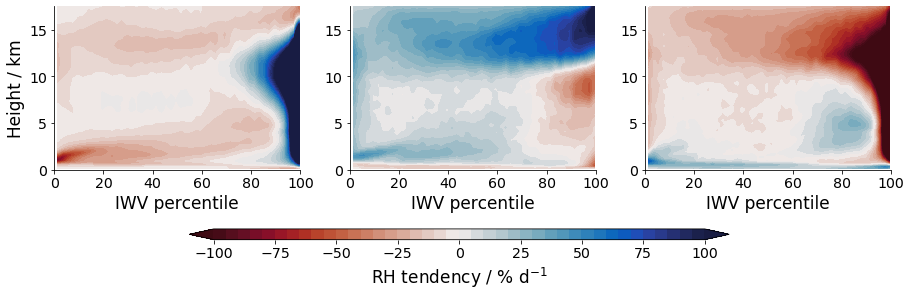

In [19]:
b = "all"
exp = 'ICON-2.5km'
plt.rcParams.update({'font.size': 17})
num_cols = 3
num_rows = 1
fig, ax = plt.subplots(num_rows, num_cols, figsize=(15, 3. * num_rows))
contours = np.arange(-100., 101., 5.)
x_lims = [0, 100]
y_lims = [0, 17.5]
im = plots.moisture_space_contourf(fig, ax[0], perc_values-0.5, h * 1e-3, (t_r['dr_dt_v_tot'][b][exp].mean.T + t_r['v_grad_r_v_tot'][b][exp].mean.T) * 1e2 * 24 * 60 * 60, contours,\
                          x_lims, y_lims, '', '', '', cb=False,
                          cm_orientation='vertical', cb_extend='both',\
                          cmap='difference_r', vmin=contours[0], vmax=contours[-1])

im = plots.moisture_space_contourf(fig, ax[1], perc_values-0.5, h * 1e-3, (t_r['tot_h'][b][exp].mean.T) * 1e2 * 24 * 60 * 60, contours,\
                          x_lims, y_lims, '', '', '', cb=False,
                          cm_orientation='vertical', cb_extend='both',\
                          cmap='difference_r', vmin=contours[0], vmax=contours[-1])

im = plots.moisture_space_contourf(fig, ax[2], perc_values-0.5, h * 1e-3, -t_r['tot'][b][exp].mean.T * 1e2 * 24 * 60 * 60, contours,\
                          x_lims, y_lims, '', '', '', cb=False,
                          cm_orientation='vertical', cb_extend='both',\
                          cmap='difference_r', vmin=contours[0], vmax=contours[-1])


#im = plots.moisture_space_contourf(fig, ax[3], perc_values-0.5, h * 1e-3, ms_perc[exp][b]['DRH_Dt_c'].mean.T * 1e2 * 24 * 60 * 60, contours,\
#                          x_lims, y_lims, '', '', '', cb=False,
#                          cm_orientation='vertical', cb_extend='both',\
#                          cmap='difference_r', vmin=contours[0], vmax=contours[-1])

ax[0].set_ylabel('Height / km')
for i in range(num_cols):
    ax[i].set_xlabel('IWV percentile')
#ax[0].set_title(r'$\frac{dr}{dt} - w \frac{\partial r}{\partial z}$')
#ax[1].set_title(r'$- u \frac{\partial r}{\partial x}$')
#ax[2].set_title(r'Sum')
cb_ax = fig.add_axes([0.25, -0.2, 0.5, 0.05])
fig.colorbar(im, cax=cb_ax, orientation='horizontal', label='RH tendency / % d$^{-1}$')
plt.savefig('plots_seminar/RH_tendencies.pdf', dpi=450)

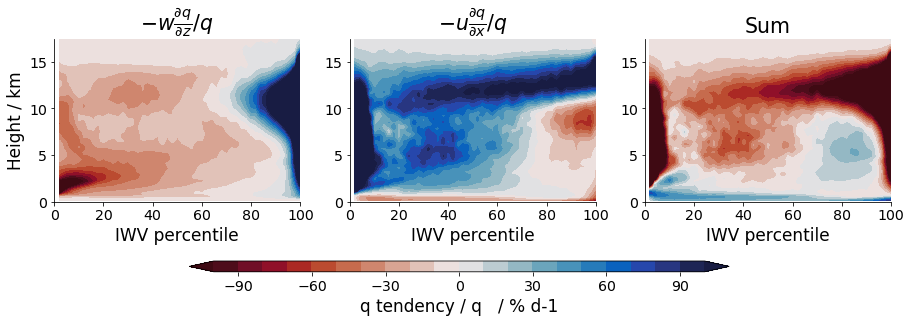

In [24]:
b = "all"
exp = 'ICON-2.5km'
plt.rcParams.update({'font.size': 17})
num_cols = 3
num_rows = 1
fig, ax = plt.subplots(num_rows, num_cols, figsize=(15, 3. * num_rows))
contours = np.arange(-100, 101, 10)
x_lims = [0, 100]
y_lims = [0, 17.5]

im = plots.moisture_space_contourf(fig, ax[0], perc_values, h * 1e-3, (t_q['tot_v'][b][exp].mean.T) / ms_perc[exp][b]['QV'].mean.T * 1e2 * 60 * 60 * 24, contours,\
                          x_lims, y_lims, '', '', '', cb=False,
                          cm_orientation='vertical', cb_extend='both',\
                          cmap='difference_r')

im = plots.moisture_space_contourf(fig, ax[1], perc_values, h * 1e-3, t_q['v_grad_q_h_tot'][b][exp].mean.T / ms_perc[exp][b]['QV'].mean.T * 1e2 * 60 * 60 * 24, contours,\
                          x_lims, y_lims, '', '', '', cb=False,
                          cm_orientation='vertical', cb_extend='both',\
                          cmap='difference_r')
    
im = plots.moisture_space_contourf(fig, ax[2], perc_values, h * 1e-3, -(t_q['tot_v'][b][exp].mean.T + t_q['v_grad_q_h_tot'][b][exp].mean.T) / ms_perc[exp][b]['QV'].mean.T * 1e2 * 60 * 60 * 24, contours,\
                          x_lims, y_lims, '', '', '', cb=False,
                          cm_orientation='vertical', cb_extend='both',\
                          cmap='difference_r')
    
ax[0].set_ylabel('Height / km')
for i in range(num_cols):
    ax[i].set_xlabel('IWV percentile')
ax[0].set_title(r'$-w \frac{\partial q}{\partial z} / q$')
ax[1].set_title(r'$-u \frac{\partial q}{\partial x} / q$')
ax[2].set_title('Sum')
cb_ax = fig.add_axes([0.25, -0.2, 0.5, 0.05])
fig.colorbar(im, cax=cb_ax, orientation='horizontal', label='q tendency / q   / % d-1')

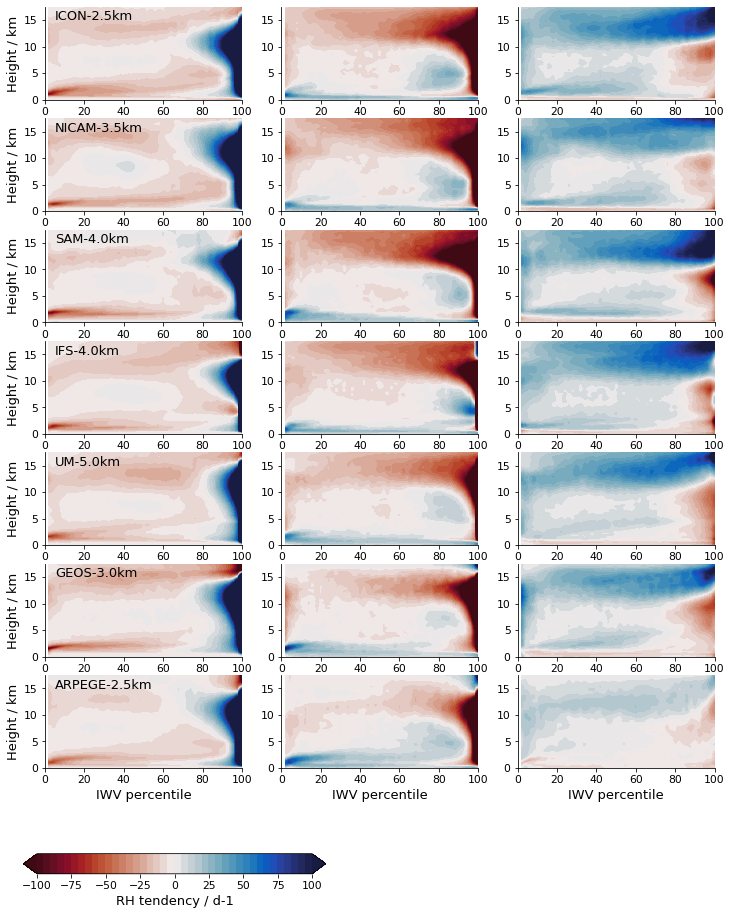

In [25]:
b = "all"
plt.rcParams.update({'font.size': 13})
num_cols = 3
num_rows = max(len(exps), 2)
fig, ax = plt.subplots(num_rows, num_cols, figsize=(12, 2. * num_rows))
contours = np.arange(-100, 101, 5.)
x_lims = [0, 100]
y_lims = [0, 17.5]
for i, exp in enumerate(exps):
    ax[i, 0].annotate(exp, (5, 15))
    im = plots.moisture_space_contourf(fig, ax[i, 0], perc_values, h * 1e-3, t_r['tot_v'][b][exp].mean.T * 1e2 * 24 * 60 * 60, contours,\
                              x_lims, y_lims, '', '', '', cb=False,
                              cm_orientation='vertical', cb_extend='both',\
                              cmap='difference_r', vmin=contours[0], vmax=contours[-1])
#     im = plots.moisture_space_contourf(fig, ax[i, 1], perc_values, h * 1e-3, t_r['dr_dt_h'][b][exp].mean.T * 24 * 60 * 60, contours,\
#                               x_lims, y_lims, '', '', '', cb=False,
#                               cm_orientation='vertical', cb_extend='both',\
#                               cmap='difference', vmin=contours[0], vmax=contours[-1])
    im = plots.moisture_space_contourf(fig, ax[i, 2], perc_values, h * 1e-3, t_r['tot_h'][b][exp].mean.T * 1e2 * 24 * 60 * 60, contours,\
                              x_lims, y_lims, '', '', '', cb=False,
                              cm_orientation='vertical', cb_extend='both',\
                              cmap='difference_r', vmin=contours[0], vmax=contours[-1])
    im = plots.moisture_space_contourf(fig, ax[i, 1], perc_values, h * 1e-3, -t_r['tot'][b][exp].mean.T * 1e2 * 24 * 60 * 60, contours,\
                              x_lims, y_lims, '', '', '', cb=False,
                              cm_orientation='vertical', cb_extend='both',\
                              cmap='difference_r', vmin=contours[0], vmax=contours[-1])
    

    ax[i, 0].set_ylabel('Height / km')
for i in range(num_cols):
    ax[-1, i].set_xlabel('IWV percentile')
#ax[0, 0].set_title(r'$\frac{dr}{dt}$ (vertical)')
#ax[0, 2].set_title(r'$- u \frac{\partial r}{\partial x}$')
#ax[0, 1].set_title(r'$- w \frac{\partial r}{\partial z}$')
#ax[0, 3].set_title(r'Sum')
cb_ax = fig.add_axes([0.10, 0.02, 0.35, 0.02])
fig.colorbar(im, cax=cb_ax, orientation='horizontal', label='RH tendency / d-1')

Anomalies in transport 

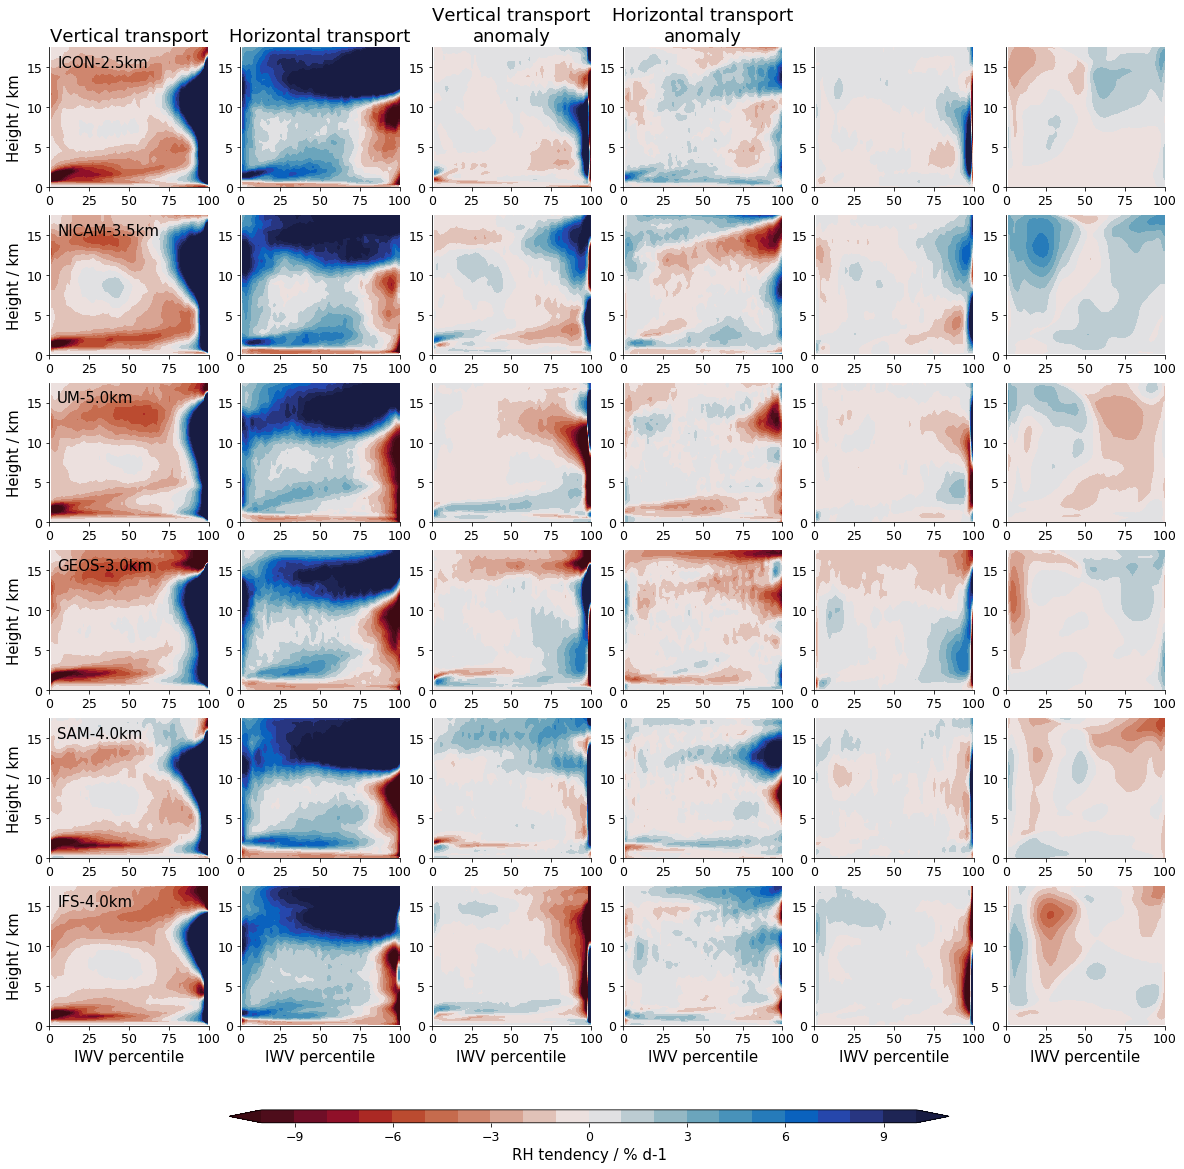

In [86]:
b = "all"
plt.rcParams.update({'font.size': 15})
num_cols = 6
num_rows = len(exps)
fig, ax = plt.subplots(num_rows, num_cols, figsize=(20, 3. * num_rows))
contours = np.arange(-40., 41., 4.)
contours_w = np.arange(-0.01, 0.011, 0.001)
contours_u = np.arange(-10., 10.01, 1.)
x_lims = [0, 100]
y_lims = [0, 17.5]

for i, exp in enumerate(exps):
    ax[i, 0].annotate(exp, (5, 15))
    im = plots.moisture_space_contourf(fig, ax[i, 0], perc_values-0.5, h * 1e-3, (t_r['tot_v'][b][exp].mean.T) * 1e2 * 24 * 60 * 60, contours,\
                              x_lims, y_lims, '', '', '', cb=False,
                              cm_orientation='vertical', cb_extend='both',\
                              cmap='difference_r', vmin=contours[0], vmax=contours[-1])
    im = plots.moisture_space_contourf(fig, ax[i, 1], perc_values-0.5, h * 1e-3, (t_r['tot_h'][b][exp].mean.T) * 1e2 * 24 * 60 * 60, contours,\
                              x_lims, y_lims, '', '', '', cb=False,
                              cm_orientation='vertical', cb_extend='both',\
                              cmap='difference_r', vmin=contours[0], vmax=contours[-1])
    
    im = plots.moisture_space_contourf(fig, ax[i, 2], perc_values-0.5, h * 1e-3, (ta_r['tot_v'][b][exp].mean.T) * 1e2 * 24 * 60 * 60, contours,\
                              x_lims, y_lims, '', '', '', cb=False,
                              cm_orientation='vertical', cb_extend='both',\
                              cmap='difference_r', vmin=contours[0], vmax=contours[-1])
    
    im = plots.moisture_space_contourf(fig, ax[i, 3], perc_values-0.5, h * 1e-3, (ta_r['tot_h'][b][exp].mean.T) * 1e2 * 24 * 60 * 60, contours,\
                              x_lims, y_lims, '', '', '', cb=False,
                              cm_orientation='vertical', cb_extend='both',\
                              cmap='difference_r', vmin=contours[0], vmax=contours[-1])
    
    im = plots.moisture_space_contourf(fig, ax[i, 4], perc_values-0.5, h * 1e-3, (ms_a['W'][b][exp].mean.T), contours_w,\
                              x_lims, y_lims, '', '', '', cb=False,
                              cm_orientation='vertical', cb_extend='both',\
                              cmap='difference_r', vmin=contours_w[0], vmax=contours_w[-1])
    
    im = plots.moisture_space_contourf(fig, ax[i, 5], perc_values-0.5, h * 1e-3, (ms_a['UV'][b][exp].mean.T), contours_u,\
                              x_lims, y_lims, '', '', '', cb=False,
                              cm_orientation='vertical', cb_extend='both',\
                              cmap='difference_r', vmin=contours_u[0], vmax=contours_u[-1])
    
    ax[i, 0].set_ylabel('Height / km')
for i in range(num_cols):
    ax[-1, i].set_xlabel('IWV percentile')

ax[0, 0].set_title('Vertical transport')
ax[0, 1].set_title('Horizontal transport')
ax[0, 2].set_title('Vertical transport\nanomaly')
ax[0, 3].set_title('Horizontal transport\nanomaly')

cb_ax = fig.add_axes([0.25, 0.05, 0.5, 0.01])
fig.colorbar(im, cax=cb_ax, orientation='horizontal', label='RH tendency / % d-1')
plt.savefig('plots_seminar/transport_anomalies.pdf', dpi=450)


Individual terms of dr/dt

Text(0.5, 1.0, 'dES_dT anomaly')

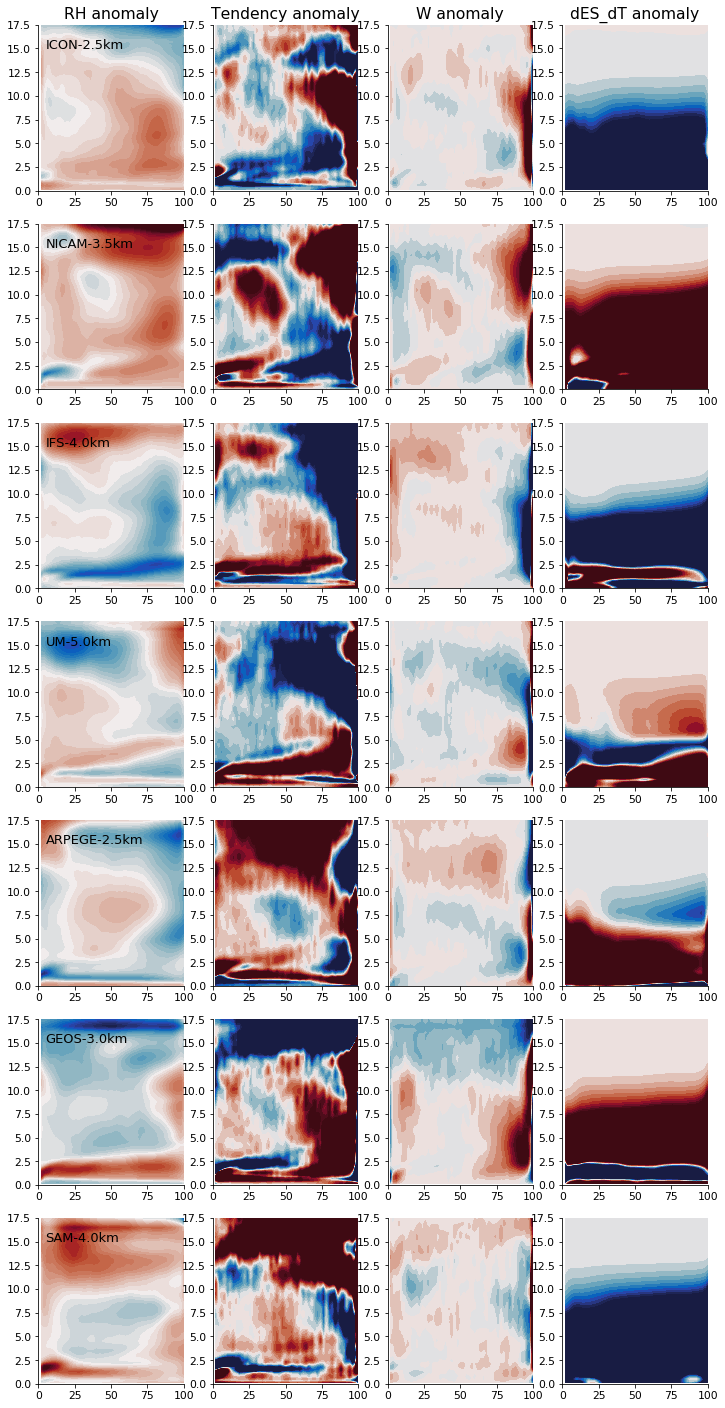

In [48]:
b = "all"
plt.rcParams.update({'font.size': 13})
fig, ax = plt.subplots(max(len(exps), 2), 4, figsize=(12, 25))
contours_rh = np.arange(-20, 20, 1)
contours_w = np.arange(-0.005000, 0.0051, 0.0005)
contours = np.arange(-0.05, 0.051, 0.005)
contours_esat = np.arange(-1.0, 1.1, 0.1)
x_lims = [0, 100]
y_lims = [0, 17.5]
for i, exp in enumerate(exps):
    ax[i, 0].annotate(exp, (5, 15))
    im = plots.moisture_space_contourf(fig, ax[i, 0], perc_values, h * 1e-3, (ms_perc[exp][b]['RH'].mean.T - ms_perc_series[b]['RH'].mean.T) * 1e2, contours_rh,\
                              x_lims, y_lims, '', '', '', cb=False,
                              cm_orientation='vertical', cb_extend='both',\
                              cmap='difference', vmin=contours_rh[0], vmax=contours_rh[-1])
    plots.moisture_space_contourf(fig, ax[i, 1], perc_values, h * 1e-3, (ta_r['tot_v'][b][exp].mean.T) * 24 * 60 * 60, contours,\
                              x_lims, y_lims, '', '', '', cb=False,
                              cm_orientation='vertical', cb_extend='both',\
                              cmap='difference', vmin=contours[0], vmax=contours[-1])
    plots.moisture_space_contourf(fig, ax[i, 2], perc_values, h * 1e-3, ms_a['W'][b][exp].mean.T, contours_w,\
                              x_lims, y_lims, '', '', '', cb=False,
                              cm_orientation='vertical', cb_extend='both',\
                              cmap='difference', vmin=contours_w[0], vmax=contours_w[-1])
    plots.moisture_space_contourf(fig, ax[i, 3], perc_values, h * 1e-3, ms_a['dES_dT'][b][exp].mean.T, contours_esat,\
                              x_lims, y_lims, '', '', '', cb=False,
                              cm_orientation='vertical', cb_extend='both',\
                              cmap='difference', vmin=contours_esat[0], vmax=contours_esat[-1])
ax[0, 0].set_title('RH anomaly')
ax[0, 1].set_title('Tendency anomaly')
ax[0, 2].set_title('W anomaly')
ax[0, 3].set_title('dES_dT anomaly')

# Anomalies in relative humidity and vertical velocity

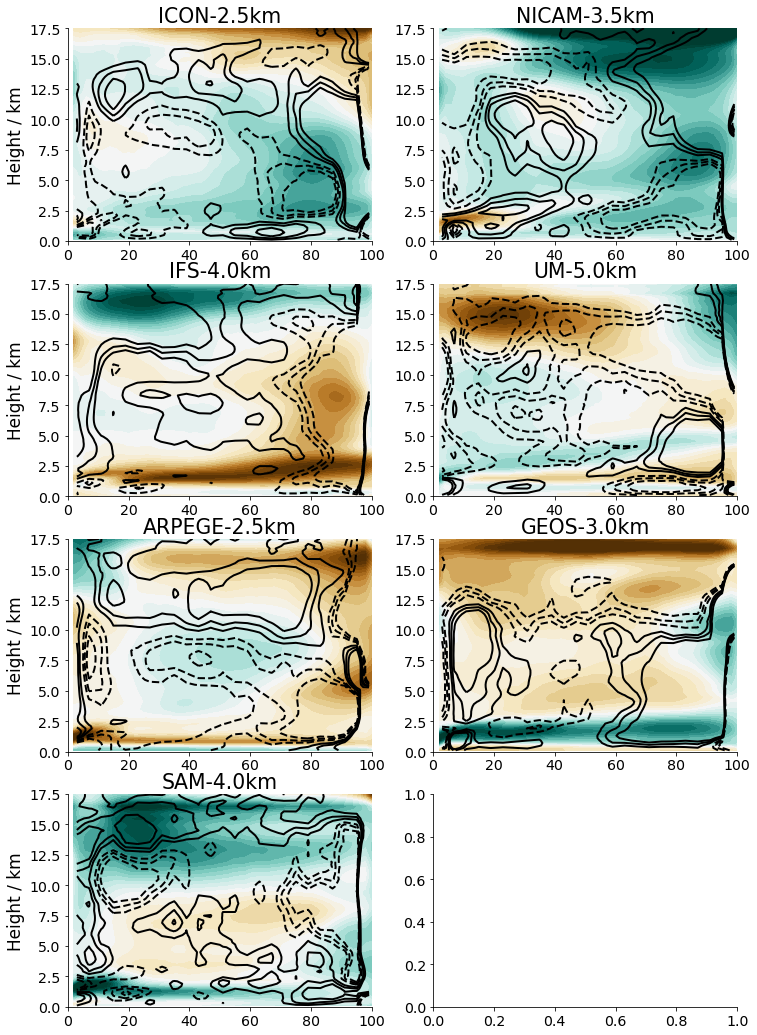

In [17]:
num_cols = 2
num_rows = int(np.ceil(len(exps) / num_cols))
fig, ax = plt.subplots(num_rows, num_cols, figsize=(12, 18))
ax = ax.ravel()
contours_rh = np.arange(-15., 15., 1.)
contours_w = [-0.0008, -0.0005, -0.00025, 0.00025, 0.0005, 0.0008]
x_lims = [0, 100]
y_lims = [0, 17.5]
x_label = 'Percentile of IWV'
y_label = 'Height / km'
perc_values_reduced = (perc_values[:-1] + 0.5 * np.diff(perc_values))[::2]
for i, exp in enumerate(exps):
    ax[i].set_title(exp)
    im = plots.moisture_space_contourf(fig, ax[i], perc_values, h * 1e-3, ms_a['RH'][b][exp].mean.T * 1e2, contours_rh,\
                              x_lims, y_lims, '', '', '', cb=False,
                              cm_orientation='vertical', cb_extend='both',\
                              cmap='BrBG', vmin=contours_rh[0], vmax=contours_rh[-1])
    plots.moisture_space_contour(fig, ax[i], perc_values_reduced, h * 1e-3, ms_a['W'][b][exp].reduced_bins(25).T, contours_w,\
                              x_lims, y_lims, '', '', color='k')
    #ax[i].contour(perc_values_reduced, h * 1e-3, ms_a['W'][b][exp].reduced_bins(25).T, [0.], color='k', linewidths=3.)
    if i%2 == 0:
        ax[i].set_ylabel(y_label)

# Difference between averaged vertical transport of q and transport with averaged vertical velocity

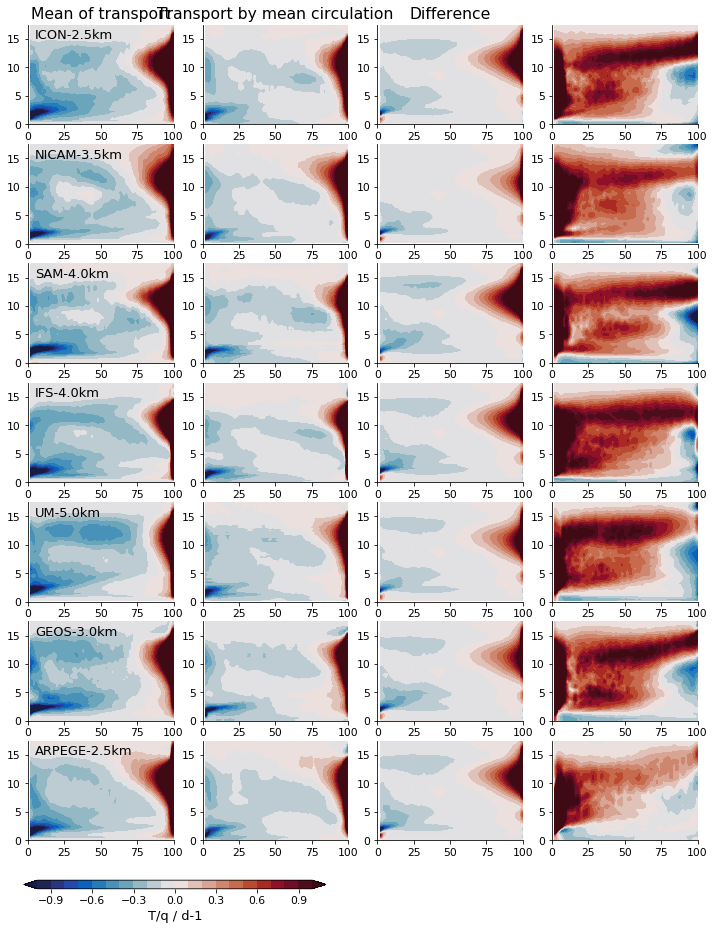

In [26]:
b = "all"
plt.rcParams.update({'font.size': 13})
fig, ax = plt.subplots(max(len(exps), 2), 4, figsize=(12, 15))
contours = np.arange(-1, 1.1, 0.1)
x_lims = [0, 100]
y_lims = [0, 17.5]
for i, exp in enumerate(exps):
    ax[i, 0].annotate(exp, (5, 15))
    
    im = plots.moisture_space_contourf(fig, ax[i, 0], perc_values, h * 1e-3, (t_q['tot_v'][b][exp].mean.T) / ms_perc[exp][b]['QV'].mean.T * 60 * 60 * 24, contours,\
                              x_lims, y_lims, '', '', '', cb=False,
                              cm_orientation='vertical', cb_extend='both',\
                              cmap='difference')
    
    im = plots.moisture_space_contourf(fig, ax[i, 1], perc_values, h * 1e-3, (t_q['v_grad_q_v'][b][exp].mean.T + t_q['v_grad_q_h'][b][exp].mean.T) / ms_perc[exp][b]['QV'].mean.T * 60 * 60 * 24, contours,\
                              x_lims, y_lims, '', '', '', cb=False,
                              cm_orientation='vertical', cb_extend='both',\
                              cmap='difference')
    
    im = plots.moisture_space_contourf(fig, ax[i, 2], perc_values, h * 1e-3, ts_q['stat'][b].mean.T / ms_perc[exp][b]['QV'].mean.T * 60 * 60 * 24, contours,\
                              x_lims, y_lims, '', '', '', cb=False,
                              cm_orientation='vertical', cb_extend='both',\
                              cmap='difference')
    im = plots.moisture_space_contourf(fig, ax[i, 3], perc_values, h * 1e-3, t_q['v_grad_q_h_tot'][b][exp].mean.T / ms_perc[exp][b]['QV'].mean.T * 60 * 60 * 24, contours,\
                              x_lims, y_lims, '', '', '', cb=False,
                              cm_orientation='vertical', cb_extend='both',\
                              cmap='difference')
    
    
    
ax[0, 0].set_title('Mean of transport')
ax[0, 1].set_title('Transport by mean circulation')
ax[0, 2].set_title('Difference')
cb_ax = fig.add_axes([0.12, 0.08, 0.35, 0.008])
fig.colorbar(im, cax=cb_ax, orientation='horizontal', label='T/q / d-1')

Transport anomaly and moisture anomaly for each model

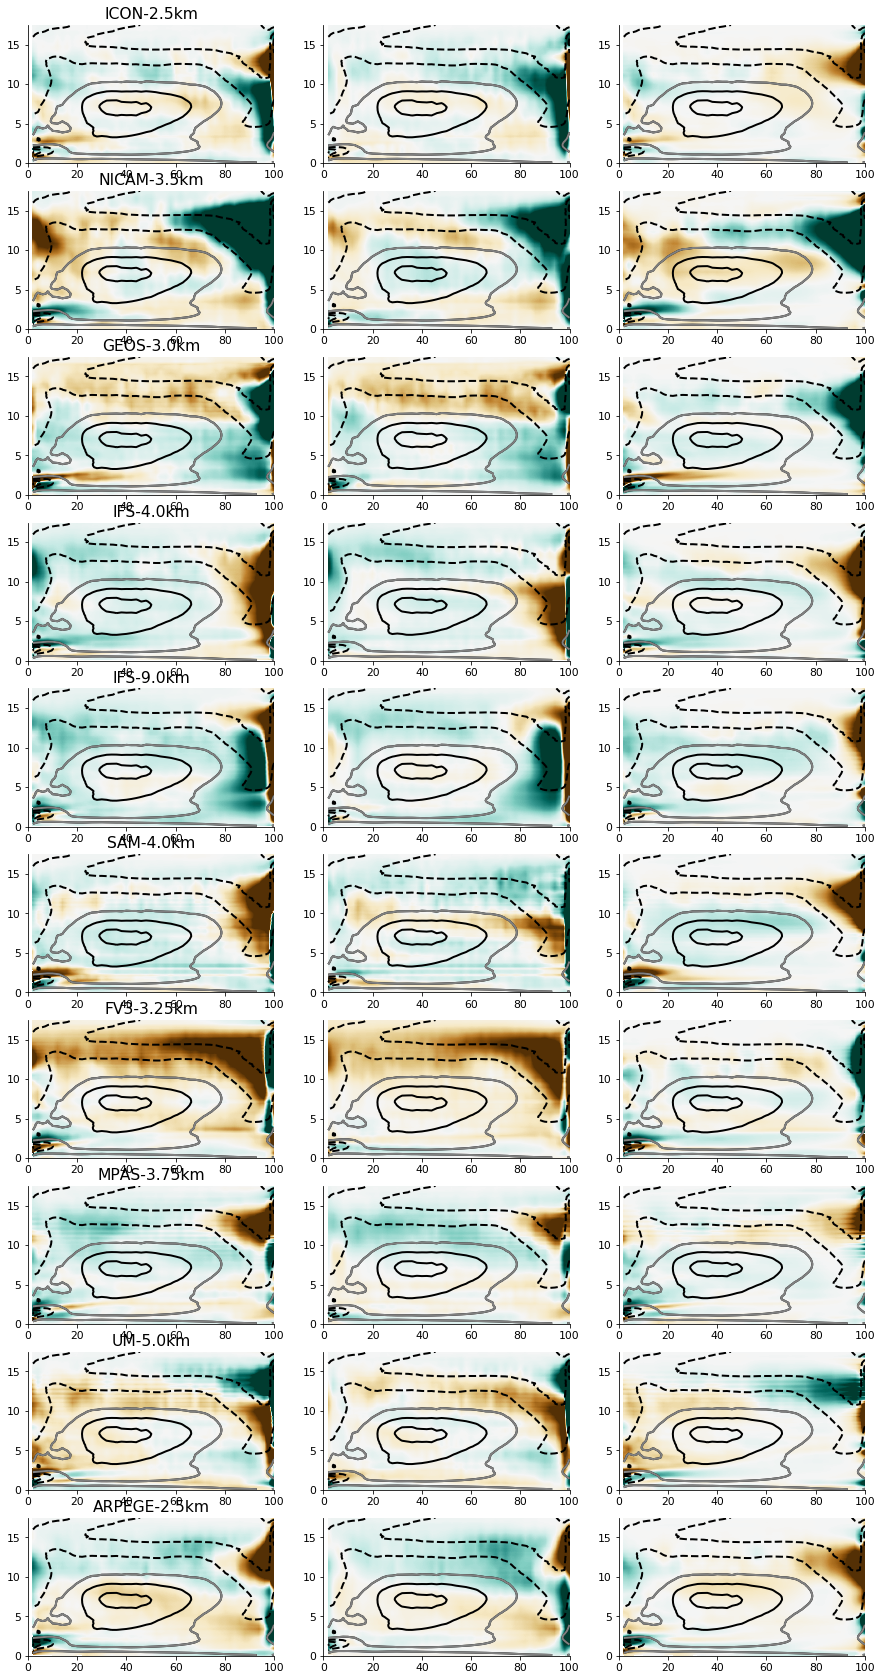

In [302]:
fig, ax = plt.subplots(len(exps), 3, figsize=(15, 30))
contours_q = np.arange(-2., 2., 0.1)
contours_ta = np.arange(-0.2, 0.201, 0.001)
for i, exp in enumerate(exps):
    ax[i, 0].set_title(exp)
    
    
    ima = plots.moisture_space_contourf(fig, ax[i, 0], perc_values, h * 1e-3, (t['v_grad_q_h'][b][exp].mean.T + t['v_grad_q_v'][b][exp].mean.T - t['vm_grad_qm_h'][b].mean.T - t['vm_grad_qm_v'][b].mean.T) / ms_perc_series[b]['QV'].mean.T * 60 * 60 * 24, contours_ta,\
                                x_lims, y_lims, '', '', 'Advection / d-1', cb=False,
                                cm_orientation='vertical', cb_extend='both',\
                                cmap='BrBG', vmin=contours_ta[0], vmax=contours_ta[-1])

    ima = plots.moisture_space_contourf(fig, ax[i, 1], perc_values, h * 1e-3, (t['va_grad_qm_h'][b][exp].mean.T + t['va_grad_qm_v'][b][exp].mean.T) / ms_perc_series[b]['QV'].mean.T * 60 * 60 * 24, contours_ta,\
                                x_lims, y_lims, '', '', 'Advection / d-1', cb=False,
                                cm_orientation='vertical', cb_extend='both',\
                                cmap='BrBG', vmin=contours_ta[0], vmax=contours_ta[-1])
    
    ima = plots.moisture_space_contourf(fig, ax[i, 2], perc_values, h * 1e-3, (t['vm_grad_qa_h'][b][exp].mean.T + t['vm_grad_qa_v'][b][exp].mean.T) / ms_perc_series[b]['QV'].mean.T * 60 * 60 * 24, contours_ta,\
                                x_lims, y_lims, '', '', 'Advection / d-1', cb=False,
                                cm_orientation='vertical', cb_extend='both',\
                                cmap='BrBG', vmin=contours_ta[0], vmax=contours_ta[-1])
    
    imq = plots.moisture_space_contour(fig, ax[i, 0], perc_values, h * 1e-3, t['qa'].mean.T / ms_perc_series[b]['QV'].mean.T, contours_q,\
                              x_lims, y_lims, '', '', color='k', vmin=contours_q[0], vmax=contours_q[-1])
    plots.moisture_space_contour(fig, ax[i, 0], perc_values, h * 1e-3, t['qa'].mean.T / ms_perc_series[b]['QV'].mean.T, [0.],\
                              x_lims, y_lims, '', '', color='grey', vmin=contours_q[0], vmax=contours_q[-1])
    imq = plots.moisture_space_contour(fig, ax[i, 1], perc_values, h * 1e-3, t['qa'].mean.T / ms_perc_series[b]['QV'].mean.T, contours_q,\
                              x_lims, y_lims, '', '', color='k', vmin=contours_q[0], vmax=contours_q[-1])
    plots.moisture_space_contour(fig, ax[i, 1], perc_values, h * 1e-3, t['qa'].mean.T / ms_perc_series[b]['QV'].mean.T, [0.],\
                              x_lims, y_lims, '', '', color='grey', vmin=contours_q[0], vmax=contours_q[-1])
    imq = plots.moisture_space_contour(fig, ax[i, 2], perc_values, h * 1e-3, t['qa'].mean.T / ms_perc_series[b]['QV'].mean.T, contours_q,\
                              x_lims, y_lims, '', '', color='k', vmin=contours_q[0], vmax=contours_q[-1])
    plots.moisture_space_contour(fig, ax[i, 2], perc_values, h * 1e-3, t['qa'].mean.T / ms_perc_series[b]['QV'].mean.T, [0.],\
                              x_lims, y_lims, '', '', color='grey', vmin=contours_q[0], vmax=contours_q[-1])
    


# Anomalies in vertical and horizontal transport

DEBUG:locator: <matplotlib.ticker.FixedLocator object at 0x2ace413c0908>
DEBUG:Using fixed locator on colorbar
DEBUG:Setting pcolormesh


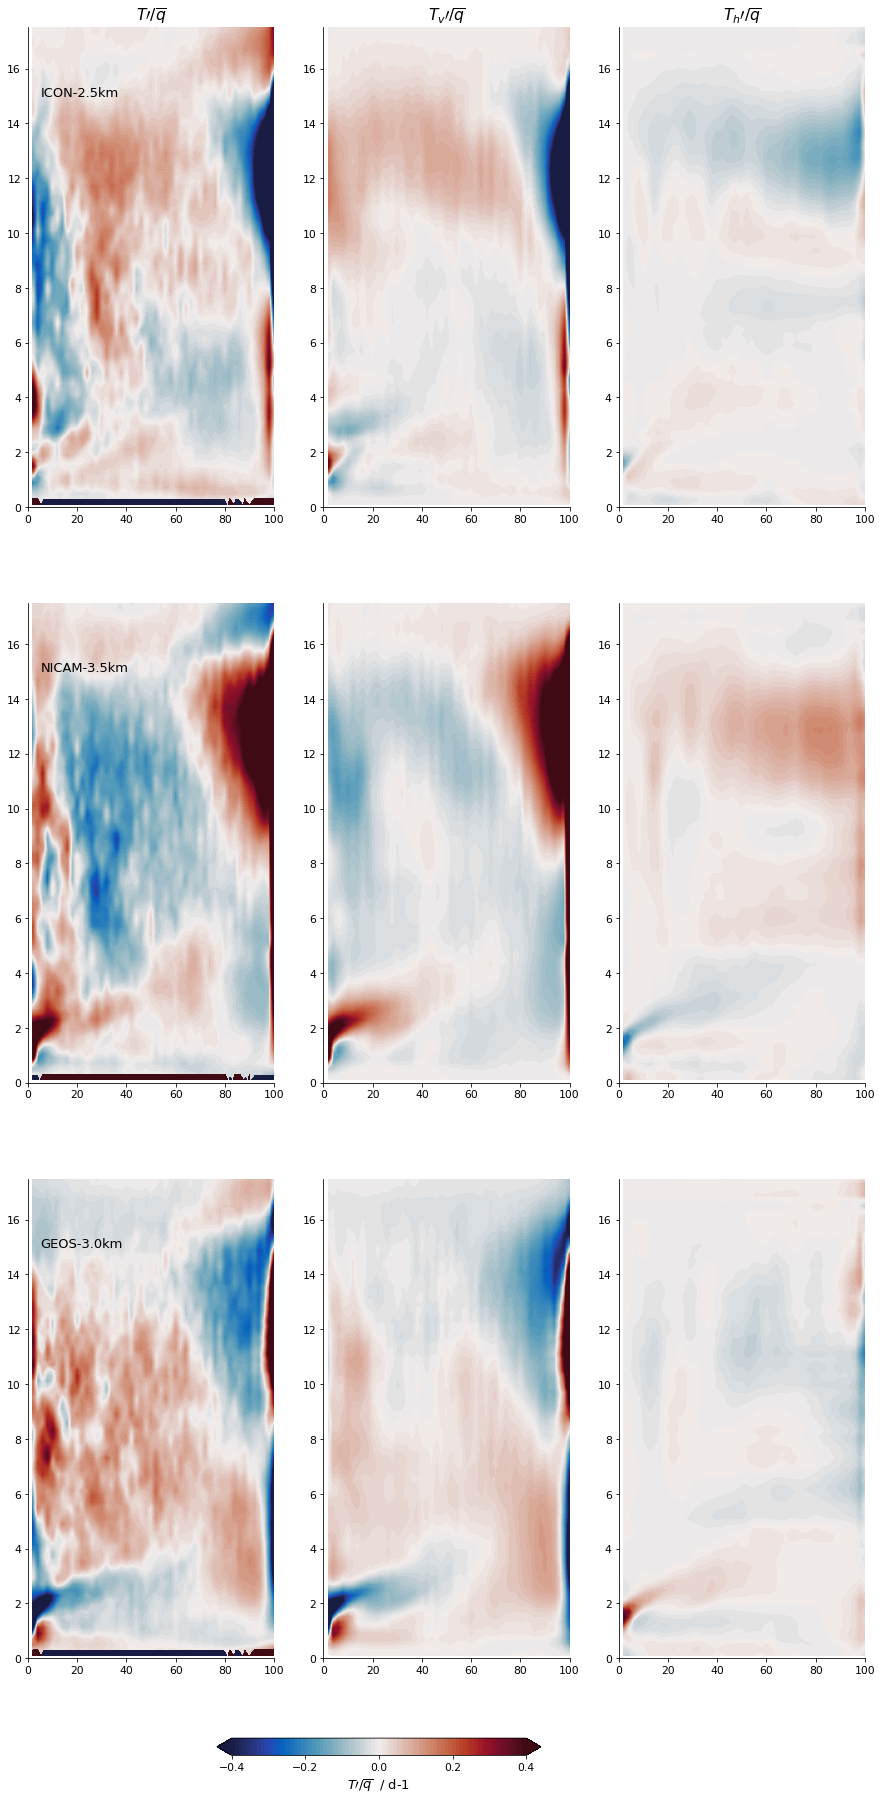

In [87]:
fig, ax = plt.subplots(len(exps), 3, figsize=(15, 30))
contours_q = np.arange(-2., 2., 0.1)
contours_ta = np.arange(-0.4, 0.401, 0.01)
for i, exp in enumerate(exps):
    ax[i, 0].annotate(exp, (5, 15))
    
    
    ima = plots.moisture_space_contourf(fig, ax[i, 0], perc_values, h * 1e-3, (ta_q['v_grad_q_h_tot'][b][exp].mean.T + ta_q['v_grad_q_v'][b][exp].mean.T) / ms_perc_series[b]['QV'].mean.T * 60 * 60 * 24, contours_ta,\
                                x_lims, y_lims, '', '', 'Advection / d-1', cb=False,
                                cm_orientation='vertical', cb_extend='both',\
                                cmap='difference', vmin=contours_ta[0], vmax=contours_ta[-1])

    ima = plots.moisture_space_contourf(fig, ax[i, 1], perc_values, h * 1e-3, ta_q['v_grad_q_v'][b][exp].mean.T / ms_perc_series[b]['QV'].mean.T * 60 * 60 * 24, contours_ta,\
                                x_lims, y_lims, '', '', 'Advection / d-1', cb=False,
                                cm_orientation='vertical', cb_extend='both',\
                                cmap='difference', vmin=contours_ta[0], vmax=contours_ta[-1])
    
    ima = plots.moisture_space_contourf(fig, ax[i, 2], perc_values, h * 1e-3, ta_q['v_grad_q_h'][b][exp].mean.T / ms_perc_series[b]['QV'].mean.T * 60 * 60 * 24, contours_ta,\
                                x_lims, y_lims, '', '', 'Advection / d-1', cb=False,
                                cm_orientation='vertical', cb_extend='both',\
                                cmap='difference', vmin=contours_ta[0], vmax=contours_ta[-1])

ax[0, 0].set_title(r'$T \prime / \overline{q}$')
ax[0, 1].set_title(r'$T_{v} \prime / \overline{q}$')
ax[0, 2].set_title(r'$T_{h} \prime / \overline{q}$')

cb_ax = fig.add_axes([0.3, 0.08, 0.3, 0.008])
fig.colorbar(ima, cax=cb_ax, orientation='horizontal', ticks=np.arange(-0.4, 0.401, 0.2), label=r'$T \prime / \overline{q}$  / d-1')

# Correlation between moisture anomalies and transport anomalies

In [27]:
reload(moisture_space)

b = 'all'
corr = {}

corr_pairs = [
    (tas_q['v_grad_q_v_tot'], ms_a_series['QV']),
    (tas_q['v_grad_q_h_tot'], ms_a_series['QV']),
    (tas_q['tot'], ms_a_series['QV']),
    (tas_r['tot'], ms_a_series['RH']),
    (tas_r['tot_v'], ms_a_series['RH']),
    (tas_r['tot_h'], ms_a_series['RH']),
    (tas_r['v_grad_r_h_tot'], ms_a_series['RH']),
    (tas_r['v_grad_r_v_tot'], ms_a_series['RH']),
    (tas_r['v_grad_r_tot'], ms_a_series['RH']),
    (tas_r['dr_dt_v_tot'], ms_a_series['RH']),
    (ms_a_series['W'], ms_a_series['RH']),
    (ms_a_series['UV'], ms_a_series['RH']),
    (ms_a_series['UV'], ms_a_series['QV'])
    
]

for c in corr_pairs:
    pair = moisture_space.MoistureSpaceSeriesPair(c[0][b], c[1][b])
    key = (c[0][b].variable, c[1][b].variable)
    corr[key] = pair.correlation(corrtype='pearson')

Text(0, 0.5, 'Height / km')

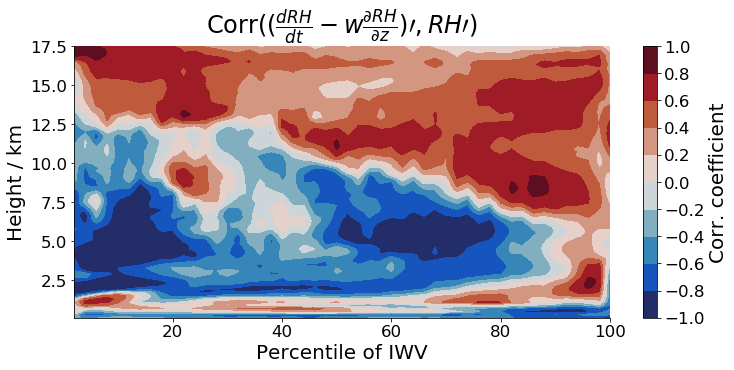

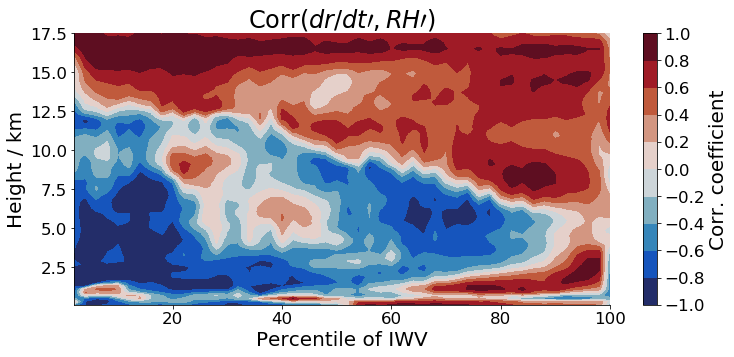

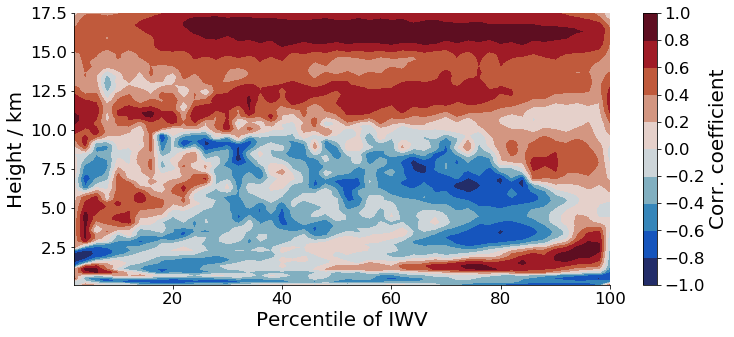

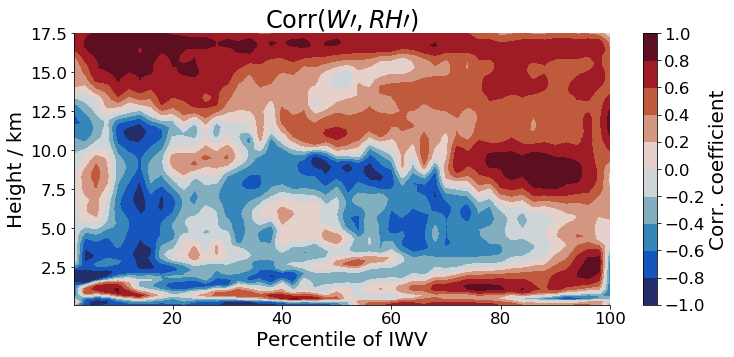

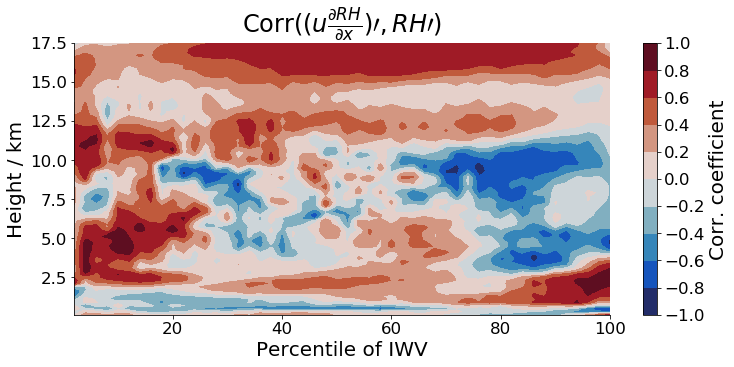

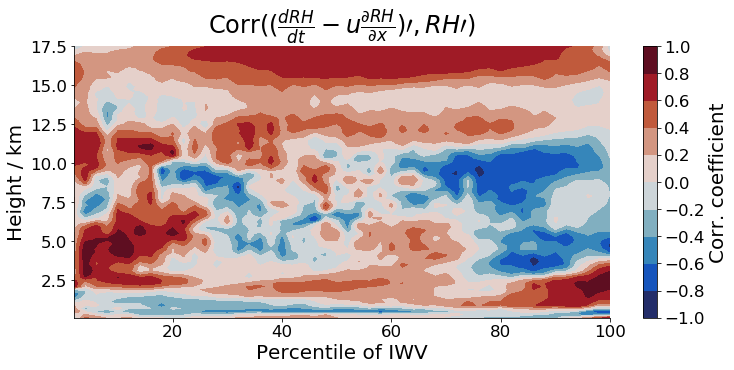

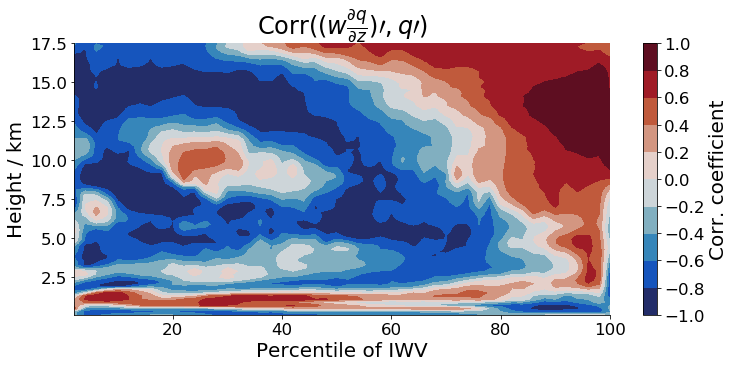

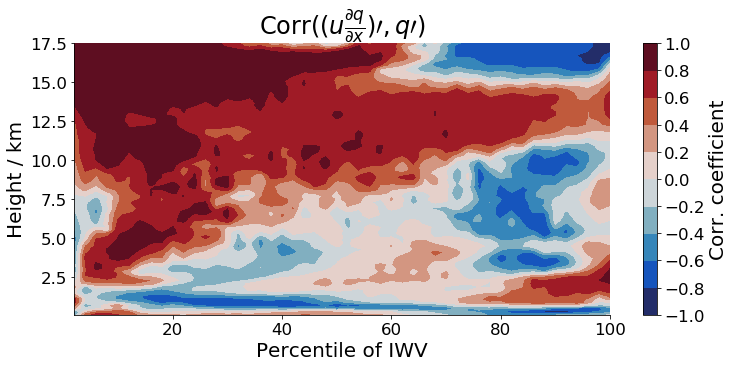

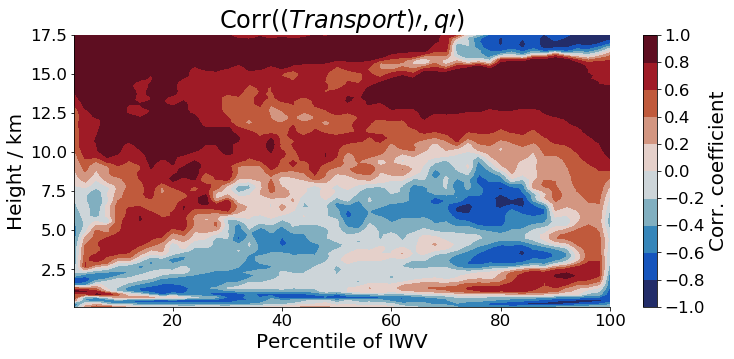

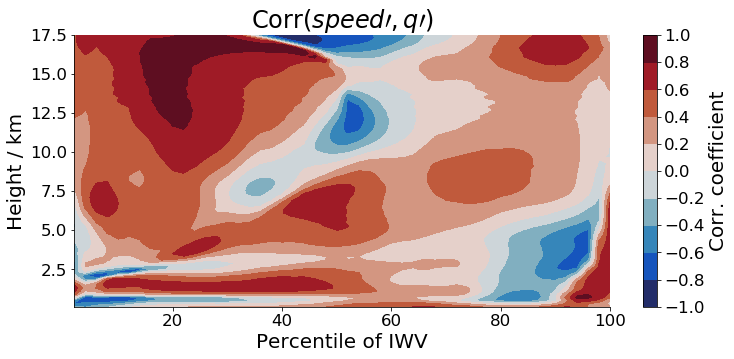

In [29]:
plt.rcParams.update({'font.size': 20})
black_contours = [-0.8, 0.8]
fig, ax = plt.subplots(figsize=(12, 5))
ax.set_title(r'Corr($(\frac{dRH}{dt} - w \frac{\partial RH}{\partial z})\prime, RH \prime$)')
im = ax.contourf(perc_values, h*1e-3, corr[('tot_v', 'RH')].T, 10, vmin=-1, vmax=1, cmap='difference')
#ax.contour(perc_values, h*1e-3, corr[('tot_v', 'RH')].T, black_contours, colors='k')
fig.colorbar(im, orientation='vertical', label='Corr. coefficient', ticks=np.arange(-1, 1.1, 0.2))
ax.set_xlabel('Percentile of IWV')
ax.set_ylabel('Height / km')
plt.savefig('plots_seminar/corr_RHtransport_v_RH.pdf', dpi=400)

fig, ax = plt.subplots(figsize=(12, 5))
ax.set_title(r'Corr($dr/dt \prime, RH \prime$)')
im = ax.contourf(perc_values, h*1e-3, corr[('dr_dt_v_tot', 'RH')].T, 10, vmin=-1, vmax=1, cmap='difference')
#ax.contour(perc_values, h*1e-3, corr[('W', 'RH')].T, black_contours, colors='k')
fig.colorbar(im, orientation='vertical', label='Corr. coefficient', ticks=np.arange(-1, 1.1, 0.2))
ax.set_xlabel('Percentile of IWV')
ax.set_ylabel('Height / km')

fig, ax = plt.subplots(figsize=(12, 5))
ax.set_title(r'Corr($transport \prime, RH \prime$)')
im = ax.contourf(perc_values, h*1e-3, corr[('tot', 'RH')].T, 10, vmin=-1, vmax=1, cmap='difference')
#ax.contour(perc_values, h*1e-3, corr[('W', 'RH')].T, black_contours, colors='k')
fig.colorbar(im, orientation='vertical', label='Corr. coefficient', ticks=np.arange(-1, 1.1, 0.2))
ax.set_xlabel('Percentile of IWV')
ax.set_ylabel('Height / km')
plt.savefig('plots_seminar/corr_RHtransport_RH.pdf', dpi=400)

fig, ax = plt.subplots(figsize=(12, 5))
ax.set_title(r'Corr($W \prime, RH \prime$)')
im = ax.contourf(perc_values, h*1e-3, corr[('W', 'RH')].T, 10, vmin=-1, vmax=1, cmap='difference')
#ax.contour(perc_values, h*1e-3, corr[('W', 'RH')].T, black_contours, colors='k')
fig.colorbar(im, orientation='vertical', label='Corr. coefficient', ticks=np.arange(-1, 1.1, 0.2))
ax.set_xlabel('Percentile of IWV')
ax.set_ylabel('Height / km')
plt.savefig('plots_seminar/corr_W_RH.pdf', dpi=400)

fig, ax = plt.subplots(figsize=(12, 5))
ax.set_title(r'Corr($(u \frac{\partial RH}{\partial x}) \prime, RH \prime$)')
im = ax.contourf(perc_values, h*1e-3, corr[('v_grad_r_h_tot', 'RH')].T, 10, vmin=-1, vmax=1, cmap='difference')
#ax.contour(perc_values, h*1e-3, corr[('W', 'RH')].T, black_contours, colors='k')
fig.colorbar(im, orientation='vertical', label='Corr. coefficient', ticks=np.arange(-1, 1.1, 0.2))
ax.set_xlabel('Percentile of IWV')
ax.set_ylabel('Height / km')

fig, ax = plt.subplots(figsize=(12, 5))
ax.set_title(r'Corr($(\frac{dRH}{dt} - u \frac{\partial RH}{\partial x}) \prime, RH \prime$)')
im = ax.contourf(perc_values, h*1e-3, corr[('tot_h', 'RH')].T, 10, vmin=-1, vmax=1, cmap='difference')
#ax.contour(perc_values, h*1e-3, corr[('W', 'RH')].T, black_contours, colors='k')
fig.colorbar(im, orientation='vertical', label='Corr. coefficient', ticks=np.arange(-1, 1.1, 0.2))
ax.set_xlabel('Percentile of IWV')
ax.set_ylabel('Height / km')

fig, ax = plt.subplots(figsize=(12, 5))
ax.set_title(r'Corr($(w \frac{\partial q}{\partial z}) \prime, q \prime$)')
im = ax.contourf(perc_values, h*1e-3, corr[('v_grad_q_v_tot', 'QV')].T, 10, vmin=-1, vmax=1, cmap='difference')
#ax.contour(perc_values, h*1e-3, corr[('ta_tot', 'qa')].T, black_contours, colors='k')
fig.colorbar(im, orientation='vertical', label='Corr. coefficient', ticks=np.arange(-1, 1.1, 0.2))
ax.set_xlabel('Percentile of IWV')
ax.set_ylabel('Height / km')

fig, ax = plt.subplots(figsize=(12, 5))
ax.set_title(r'Corr($(u \frac{\partial q}{\partial x}) \prime, q \prime$)')
im = ax.contourf(perc_values, h*1e-3, corr[('v_grad_q_h_tot', 'QV')].T, 10, vmin=-1, vmax=1, cmap='difference')
#ax.contour(perc_values, h*1e-3, corr[('ta_tot', 'qa')].T, black_contours, colors='k')
fig.colorbar(im, orientation='vertical', label='Corr. coefficient', ticks=np.arange(-1, 1.1, 0.2))
ax.set_xlabel('Percentile of IWV')
ax.set_ylabel('Height / km')
plt.savefig('plots_seminar/corr_RHtransport_h_RH.pdf', dpi=400)

fig, ax = plt.subplots(figsize=(12, 5))
ax.set_title(r'Corr($(Transport) \prime, q \prime$)')
im = ax.contourf(perc_values, h*1e-3, corr[('tot', 'QV')].T, 10, vmin=-1, vmax=1, cmap='difference')
#ax.contour(perc_values, h*1e-3, corr[('ta_tot', 'qa')].T, black_contours, colors='k')
fig.colorbar(im, orientation='vertical', label='Corr. coefficient', ticks=np.arange(-1, 1.1, 0.2))
ax.set_xlabel('Percentile of IWV')
ax.set_ylabel('Height / km')

fig, ax = plt.subplots(figsize=(12, 5))
ax.set_title(r'Corr($speed \prime, q \prime$)')
im = ax.contourf(perc_values, h*1e-3, corr[('UV', 'QV')].T, 10, vmin=-1, vmax=1, cmap='difference')
#ax.contour(perc_values, h*1e-3, corr[('ta_tot', 'qa')].T, black_contours, colors='k')
fig.colorbar(im, orientation='vertical', label='Corr. coefficient', ticks=np.arange(-1, 1.1, 0.2))
ax.set_xlabel('Percentile of IWV')
ax.set_ylabel('Height / km')


# black_contours = [-0.8, 0.8]
# fig, ax = plt.subplots(figsize=(12, 5))
# ax.set_title(r'Corr($T \prime, q \prime$) - Transport with mean circulation')
# #ax.set_title(r'Corr($\vec{v} \prime \nabla{\overline{q}} + \overline{\vec{v}} \nabla{q \prime} + \vec{v} \prime \nabla{q \prime}, q \prime$)')
# im = ax.contourf(perc_values, h*1e-3, corr[('ta', 'qa')].T, 10, vmin=-1, vmax=1, cmap='difference')
# #ax.contour(perc_values, h*1e-3, corr[('ta', 'qa')].T, black_contours, colors='k')
# fig.colorbar(im, orientation='vertical', label='Corr. coefficient', ticks=np.arange(-1, 1.1, 0.2))
# ax.set_xlabel('Percentile of IWV')
# ax.set_ylabel('Height / km')

# fig, ax = plt.subplots(figsize=(12, 5))
# ax.set_title(r'Corr($\vec{v} \prime \nabla{\overline{q}}, q \prime$)')
# im = ax.contourf(perc_values, h*1e-3, corr[('tva', 'qa')].T, 10, vmin=-1, vmax=1, cmap='difference')
# ax.contour(perc_values, h*1e-3, corr[('tva', 'qa')].T, black_contours, colors='k')
# fig.colorbar(im, orientation='vertical')
# ax.set_xlabel('Percentile of IWV')
# ax.set_ylabel('Height / km')

# fig, ax = plt.subplots(figsize=(12, 5))
# ax.set_title(r'Corr($\overline{\vec{v}} \nabla{q \prime}, q \prime$)')
# im = ax.contourf(perc_values, h*1e-3, corr[('tqa', 'qa')].T, 10, vmin=-1, vmax=1, cmap='difference')
# ax.contour(perc_values, h*1e-3, corr[('tqa', 'qa')].T, black_contours, colors='k')
# fig.colorbar(im, orientation='vertical')
# ax.set_xlabel('Percentile of IWV')
# ax.set_ylabel('Height / km')

NameError: name 'corr' is not defined

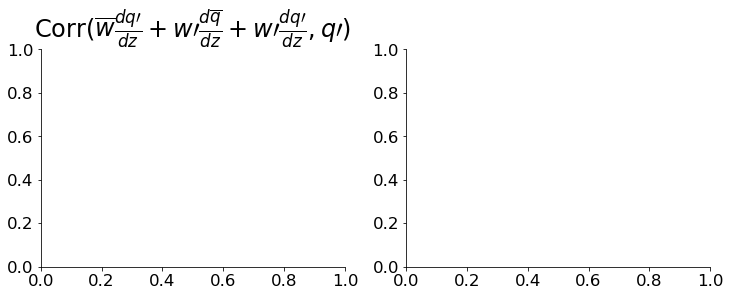

In [26]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
ax[0].set_title(r'Corr($\overline{w} \frac{d q \prime}{dz} + w \prime \frac{d \overline{q}}{dz} + w \prime \frac{d q \prime}{dz}, q \prime$)')
ax[0].contourf(perc_values, h*1e-3, corr[('ta_v', 'qa')].T, 10, vmin=-1, vmax=1, cmap='difference')
ax[1].set_title(r'Corr($\overline{u} \frac{d q \prime}{dx} + u \prime \frac{d \overline{q}}{dx} + u \prime \frac{d q \prime}{dx}, q \prime$)')
ax[1].contourf(perc_values, h*1e-3, corr[('ta_h', 'qa')].T, 10, vmin=-1, vmax=1, cmap='difference')


(-0.003, 0.003)

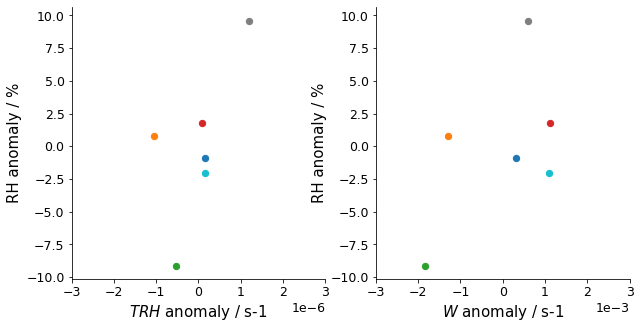

In [144]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
p = [20, 14000]
ind_h = np.argmin(np.abs(perc_values - p[0]))
ind_v = np.argmin(np.abs(h - p[1]))

for i, exp in enumerate(exps):
    ax[0].scatter(ta_r['tot'][b][exp].mean[ind_h, ind_v], ms_a['RH'][b][exp].mean[ind_h, ind_v] * 1e2, s=40, color=plots.DYAMOND_colors(exp))
    ax[1].scatter(ms_a['W'][b][exp].mean[ind_h, ind_v], ms_a['RH'][b][exp].mean[ind_h, ind_v] * 1e2, s=40, color=plots.DYAMOND_colors(exp))
ax[0].set_xlabel('$TRH$ anomaly / s-1')
ax[0].set_ylabel('RH anomaly / %')
ax[1].set_xlabel('$W$ anomaly / s-1')
ax[1].set_ylabel('RH anomaly / %')
ax[0].set_xlim(-0.000003, 0.000003)
ax[1].set_xlim(-0.003, 0.003)

DEBUG:locator: <matplotlib.ticker.FixedLocator object at 0x2ae1123faef0>
DEBUG:Using fixed locator on colorbar
DEBUG:Setting pcolormesh


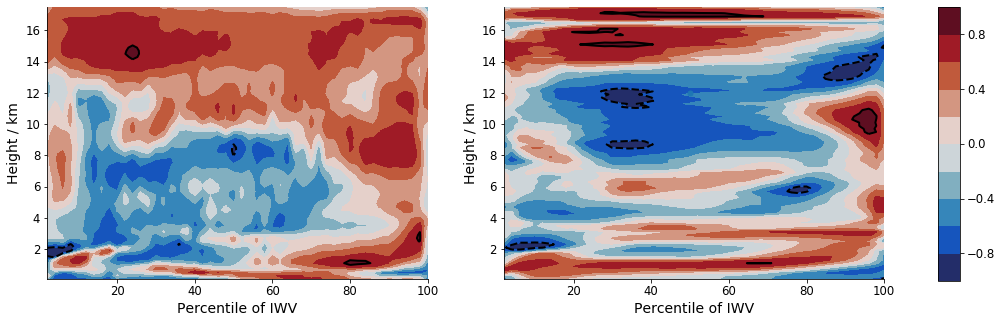

In [542]:
plt.rcParams.update({'font.size': 14})
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
contours = [-1, -0.9, -0.8, -0.7, 0.7, 0.8, 0.9, 1.0]
im = ax[0].contourf(perc_values, h*1e-3, corr[('wa', 'ra')].T, 10, vmin=-1, vmax=1, cmap='difference')
ax[1].contourf(perc_values, h*1e-3, corr[('ua', 'ra')].T, 10, vmin=-1, vmax=1, cmap='difference')
ax[0].contour(perc_values, h*1e-3, corr[('wa', 'ra')].T, [-0.8, 0.8], colors='k')
ax[1].contour(perc_values, h*1e-3, corr[('ua', 'ra')].T, [-0.8, 0.8], colors='k')
ax[1].plot(50, 12, '.')
ax[0].set_xlabel('Percentile of IWV')
ax[1].set_xlabel('Percentile of IWV')
ax[0].set_ylabel('Height / km')
ax[1].set_ylabel('Height / km')
cb_ax = fig.add_axes([0.95, 0.12, 0.02, 0.76])
fig.colorbar(im, cax=cb_ax)